# 19. Click EDA

Specifically look at notebook clicks and see if the answer the user selected is not in there. This would be a massive data leak but it will solve the competition.

## Web References

- https://www.kaggle.com/competitions/predict-student-performance-from-game-play/discussion/388094
- https://www.kaggle.com/code/cdeotte/game-room-click-eda

In [3]:
import os
import sys
import gc
import math
import logging
from typing import Tuple

import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import multiprocessing
from functools import partial

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers

import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, concatenate
from keras import callbacks


import matplotlib.pyplot as plt

2023-03-07 18:42:07.818692: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

In [5]:
# Set the GPU memory from growth
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-03-07 18:42:08.978175: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 18:42:08.980028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 18:42:08.980160: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Configure Logging

In [6]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
        handlers=[
        logging.FileHandler("ex05_06.log"),
        logging.StreamHandler(sys.stdout)
    ])

logging.info("Started")

2023-03-07 18:42:09 INFO     Started


## Load Source Data

In [7]:
# load the source training set
df_source = pd.read_csv('data/train.csv.gz', compression='gzip', index_col=1)

print(df_source.shape)
with pd.option_context('display.max_columns', None):
    display(df_source.head(3))

(13174211, 19)


,session_id,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
index,,,,,,,,,,,,,,,,,,,
0,20090312431273200,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [8]:
# load the source training labels
df_source_labels = pd.read_csv('data/train_labels.csv')

print(df_source_labels.shape)
with pd.option_context('display.max_columns', None):
    display(df_source_labels.head(3))

(212022, 2)


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1


## Functions

### Functions to prepare the data

In [9]:
def map_question_to_level_group(question_number):
    """
    Maps the question number to the level group.

    Parameters
    ----------
    question_number : int
        The question number.

    Returns
    -------
    str
        The level group.
    """
    if question_number in [1, 2, 3]:
        return '0-4'
    elif question_number in [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]:
        return '5-12'
    elif question_number in [14, 15, 16, 17, 18]:
        return '13-22'
    else:
        return None

def prepare_label_dataset(data : pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the label dataset and add columns for the level group 
    and the question number.

    Parameters
    ----------
    data : pd.DataFrame
        The label dataset.

    Returns
    -------
    pd.DataFrame
        The prepared label dataset.
    """
    # add the columns to determine the level group
    df_labels = data \
        .rename(columns={'session_id': 'id'}) \
        .assign(session_id=lambda df: df['id'].str.split('_').str[0].astype(int)) \
        .assign(question_id=lambda df: df['id'].str.split('_').str[1]) \
        .assign(question_num=lambda df: df['question_id'].str[1:].astype(int)) \
        [['session_id', 'question_num', 'correct']]
    
    # add the level group column
    df_labels['level_group'] = df_labels['question_num'].apply(map_question_to_level_group) 
        
    return df_labels

In [10]:
def prepare_main_dataset(data : pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the main dataset by removing duplicates and removing 
    columns that are not needed.

    Parameters
    ----------
    data : pd.DataFrame
        The main dataset.

    Returns
    -------
    pd.DataFrame
        The prepared main dataset.
    """
    empty_columns = ['fullscreen', 'hq', 'music', 'page', 'hover_duration']

    df_main = data \
        .drop_duplicates() \
        .reset_index(drop=True) \
        .drop(empty_columns, axis=1) \
        .drop('text', axis=1)

    return df_main

In [11]:
def select_sessions(
        y: pd.DataFrame,
        sample_size: int,
        random_state: int=1337) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Selects a sample of sessions from the dataset.

    Parameters
    ----------
    y : pd.DataFrame
        The label dataset.
    sample_size : int
        The number of sessions to select.
    random_state : int
        The random state to use.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray, np.ndarray]
        The selected session ids, the main dataset and the label dataset.
    """
    # select all the unique session ids
    all_session_ids = y['session_id'].unique()

    # create a sample for testing
    session_ids = np.random.choice(all_session_ids, size=sample_size, replace=False)

    # split the dataset into train, validation and test sets
    train, test = train_test_split(session_ids, test_size=0.3)
    test, val = train_test_split(test, test_size=0.5)

    # print the number of sessions in each set
    print(f'Train: {len(train)}')
    print(f'Validation: {len(val)}')
    print(f'Test: {len(test)}')

    return train, val, test

### Functions for Model Training

In [12]:
def plot_loss(history: callbacks.History, figsize: Tuple[int, int] = (5, 3)) -> None:
    """
    Plot the loss and validation loss.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for loss
    plt.figure(figsize=figsize)
    plt.plot(epochs, history.history['loss'])
    
    if ('val_loss' in history.history):
        plt.plot(epochs, history.history['val_loss'])
        plt.legend(['Training loss', 'Validation loss'], loc='upper left')
        plt.title('Training and validation loss')
    else:
        plt.title('Training loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()

In [13]:
def plot_accuracy(history: callbacks.History, figsize: Tuple[int, int] = (5, 3)) -> None:
    """
    Plot the accuracy and validation accuracy.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for accuracy
    plt.figure(figsize=figsize)
    plt.plot(epochs, history.history['accuracy'])

    if ('val_accuracy' in history.history):
        plt.plot(epochs, history.history['val_accuracy'])
        plt.legend(['Training acc', 'Validation acc'], loc='upper left')
        plt.title('Training and validation accuracy')
    else:
        plt.title('Training accuracy')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.show()

In [14]:
def test_model(
        model,
        history: callbacks.History,
        X_test: np.ndarray,
        y_test: np.ndarray) -> float:
    """
    Test the model based on the test data.

    Parameters
    ----------
    model : keras.models
        The model to test.
    history : keras.callbacks.History
        The history of the training.
    X_test : np.ndarray
        The test data.
    y_test : np.ndarray
        The test labels.

    Returns
    -------
    float
        The optimized threshold for the best F1 score.
    """
    
    plot_loss(history)
    plot_accuracy(history)

    y_test_score = model.predict(X_test)
    threshold, _, _ = optimize_f1(y_test, y_test_score)

    print(classification_report(y_test, y_test_score > threshold))
    print(f'Optimized threshold for best F1: {threshold:.2f}')

    gc.collect()

    return threshold

In [15]:
def optimize_f1(y_true: np.ndarray, y_score: np.ndarray) -> Tuple[float, float, float]:
    """
    Optimize the F1 score.

    Parameters
    ----------
    y_true : np.ndarray
        The true labels.
    y_score : np.ndarray
        The predicted labels.

    Returns
    -------
    Tuple[float, float, float]
        The optimized threshold, precision, and recall.
    """
    best_f1 = 0
    best_threshold = 0
    best_precision = 0
    best_recall = 0

    for threshold in np.arange(0, 1, 0.01):
        y_pred = (y_score > threshold).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=1)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_precision = precision
            best_recall = recall

    return best_threshold, best_precision, best_recall

In [16]:
def train_model(
        model,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_val : np.ndarray,
        y_val: np.ndarray,
        epochs: int,
        batch_size: int,
        optimizer,
        loss: str,
        metrics: list,
        class_weight: dict=None) -> callbacks.History:
    """
    Train the keras model based on the parameters.

    Parameters
    ----------
    model : keras.models
        The model to train.
    X_train : np.ndarray
        The training data.
    y_train : np.ndarray
        The training labels.
    X_val : np.ndarray
        The validation data.
    y_val : np.ndarray
        The validation labels.
    epochs : int
        The number of epochs.
    batch_size : int
        The batch size.
    optimizer : keras.optimizers
        The optimizer.
    loss : str
        The loss function.
    metrics : list
        The metrics.
    class_weight : dict, optional
        The class weights, by default None
    
    Returns
    -------
    keras.callbacks.History
        The history of the training.
    """
    # compile the model
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics)
    
    # fit the model
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        class_weight=class_weight)
    
    return history

In [17]:
def test_model(
        model,
        history: callbacks.History,
        X_test: np.ndarray,
        y_test: np.ndarray) -> float:
    """
    Test the model based on the test data.

    Parameters
    ----------
    model : keras.models
        The model to test.
    history : keras.callbacks.History
        The history of the training.
    X_test : np.ndarray
        The test data.
    y_test : np.ndarray
        The test labels.

    Returns
    -------
    float
        The optimized threshold for the best F1 score.
    """
    
    plot_loss(history)
    plot_accuracy(history)

    y_test_score = model.predict(X_test)
    #print(y_test_score[1], y_test[1])
    threshold, _, _ = optimize_f1(y_test, y_test_score)
    
    threshold = 0.5
    y_test_pred = (y_test_score > threshold).astype(float)
    print(y_test[1])
    print(y_test_pred[1])

    print(classification_report(y_test, y_test_score > threshold))
    #print(classification_report(y_test, y_test_score))
    print(f'Optimized threshold for best F1: {threshold:.2f}')

    gc.collect()

    return threshold

In [18]:
def train_and_test_model(
        model,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_val : np.ndarray,
        y_val: np.ndarray,
        X_test: np.ndarray,
        y_test: np.ndarray,
        epochs: int,
        batch_size: int,
        optimizer,
        loss: str,
        metrics: list,
        class_weight: dict=None) -> float:
    """
    Train and test the model.

    Parameters
    ----------
    model : keras.models
        The model to train and test.
    X_train : np.ndarray
        The training data.
    y_train : np.ndarray
        The training labels.
    X_val : np.ndarray
        The validation data.
    y_val : np.ndarray
        The validation labels.
    X_test : np.ndarray
        The test data.
    y_test : np.ndarray
        The test labels.
    epochs : int
        The number of epochs.
    batch_size : int
        The batch size.
    optimizer : keras.optimizers
        The optimizer.
    loss : str
        The loss function.
    metrics : list
        The metrics.
    class_weight : dict, optional
        The class weights, by default None

    Returns
    -------
    float
        The optimized threshold for the best F1 score.
    """
    history = train_model(
        model=model,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
        class_weight=class_weight)
    
    gc.collect()

    return test_model(model, history, X_test, y_test)

## Value Ranges

event_name - the name of the event type

In [19]:
df_source.event_name.value_counts()

navigate_click        5687896
person_click          3024847
cutscene_click        1351732
object_click          1099670
object_hover           529116
map_hover              471621
notification_click     324106
notebook_click         284746
map_click              258714
observation_click      106260
checkpoint              35503
Name: event_name, dtype: int64

name - the event name (e.g. identifies whether a notebook_click is is opening or closing the notebook)

In [20]:
df_source.name.value_counts()

undefined    6377305
basic        6324016
close         339093
open          118125
prev            9834
next            5838
Name: name, dtype: int64

fqid - the fully qualified ID of the event

In [21]:
df_source.fqid.value_counts()

worker           939555
archivist        563259
gramps           561000
wells            394234
toentry          392221
                  ...  
block_badge         854
need_glasses        675
block_badge_2       508
fox                 166
block_1              25
Name: fqid, Length: 127, dtype: int64

room_fqid - the fully qualified ID of the room the event took place in

In [22]:
df_source.room_fqid.value_counts()

tunic.historicalsociety.entry              1816202
tunic.wildlife.center                      1510888
tunic.historicalsociety.cage               1178391
tunic.library.frontdesk                    1075322
tunic.historicalsociety.frontdesk           972235
tunic.historicalsociety.stacks              900673
tunic.historicalsociety.closet_dirty        788096
tunic.humanecology.frontdesk                662645
tunic.historicalsociety.basement            585058
tunic.kohlcenter.halloffame                 547779
tunic.library.microfiche                    497924
tunic.drycleaner.frontdesk                  492050
tunic.historicalsociety.collection          478700
tunic.historicalsociety.closet              429854
tunic.flaghouse.entry                       416942
tunic.historicalsociety.collection_flag     227017
tunic.capitol_1.hall                        223793
tunic.capitol_0.hall                        208670
tunic.capitol_2.hall                        161972
Name: room_fqid, dtype: int64

text_fqid - the fully qualified ID of the

In [23]:
df_source.text_fqid.value_counts()

tunic.historicalsociety.cage.confrontation               333363
tunic.wildlife.center.crane_ranger.crane                 235368
tunic.historicalsociety.frontdesk.archivist.newspaper    214637
tunic.historicalsociety.entry.groupconvo                 213592
tunic.wildlife.center.wells.nodeer                       199978
                                                          ...  
tunic.wildlife.center.fox.concern                           111
tunic.drycleaner.frontdesk.block_0                          106
tunic.historicalsociety.entry.gramps.hub                     21
tunic.humanecology.frontdesk.block_1                          8
tunic.drycleaner.frontdesk.block_1                            3
Name: text_fqid, Length: 126, dtype: int64

## Checkpoint Events

In [24]:
df_source[df_source['event_name'] == 'checkpoint'] \
    .groupby(['name', 'level', 'fqid', 'room_fqid', 'level_group']) \
    .agg({'event_name': 'count'})

event_name
name  level fqid           room_fqid            level_group            
basic 4     chap1_finale_c tunic.capitol_0.hall 0-4               11851
      12    chap2_finale_c tunic.capitol_1.hall 5-12              11838
      22    chap4_finale_c tunic.capitol_2.hall 13-22             11814

In [25]:
session_id = 20090314121766812
level_group = '13-22'

df_session = df_source.query('session_id == @session_id and level_group == @level_group')

print(df_session.shape)
with pd.option_context('display.max_columns', None):
    with pd.option_context('display.max_rows', None):
        #display(df_session)
        pass

(488, 19)


In [26]:
df_session \
    .groupby(['fqid', 'level']) \
    .agg({'event_name': 'count'}) \
    .sort_values(by='event_name', ascending=False)

event_name
fqid          level            
wells         18             29
confrontation 16             21
flag_girl     19             19
crane_ranger  18             16
expert        18             15
...                         ...
tomap         19              1
              20              1
tomicrofiche  20              1
tostacks      16              1
toentry       13              1

[91 rows x 1 columns]

In [27]:
df_session.fqid.value_counts()

wells                           29
confrontation                   21
flag_girl                       19
crane_ranger                    16
worker                          16
expert                          15
groupconvo_flag                 13
seescratches                    12
archivist_glasses               10
tomap                            9
gramps                           9
toentry                          9
glasses                          9
tunic.drycleaner                 8
tunic.capitol_2                  8
ch3start                         8
savedteddy                       7
journals_flag.pic_0.next         6
tunic.wildlife                   6
lockeddoor                       6
tunic.historicalsociety          5
tostacks                         5
journals_flag.pic_0.bingo        5
tobasement                       5
tunic.library                    5
boss                             5
tunic.kohlcenter                 4
unlockdoor                       4
tocollectionflag    

In [28]:
df_session.level.value_counts()

18    160
21     76
15     58
20     38
16     35
13     33
19     33
17     30
14     15
22     10
Name: level, dtype: int64

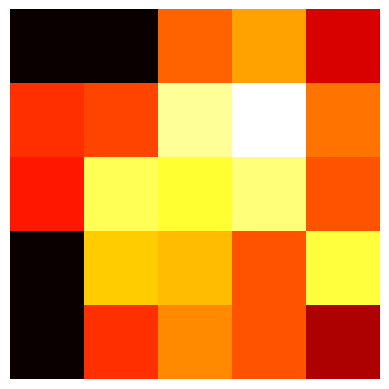

In [29]:
def create_heatmap(screen_coor_x, screen_coor_y):
    # Create the 2D histogram
    heatmap, xedges, yedges = np.histogram2d(
        x=screen_coor_y, 
        y=screen_coor_x, 
        bins=5)

    # Apply logarithmic transformation
    heatmap = np.log(heatmap + 1)

    # Normalize the heatmap
    normalized_heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

    # Scale the heatmap to the range 0-255
    scaled_heatmap = (normalized_heatmap * 255).astype(np.uint8)

    return scaled_heatmap

# test the heatmap function
df_plot = df_session[['room_coor_x', 'room_coor_y']].dropna()
x = df_plot.room_coor_x
y = df_plot.room_coor_y

heatmap = create_heatmap(x, y)
plt.imshow(heatmap, cmap='hot', origin='lower')
plt.axis('off')
plt.show()

In [30]:
print('X  max:', df_source.room_coor_x.max(), 'min:', df_source.room_coor_x.min())
print('Y max:', df_source.room_coor_y.max(), 'min:', df_source.room_coor_y.min())


X  max: 1261.7737454550663 min: -1992.3545688360275
Y max: 543.616424379599 min: -918.1586870421452


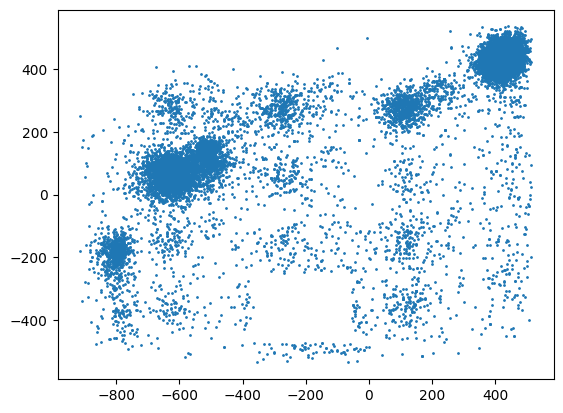

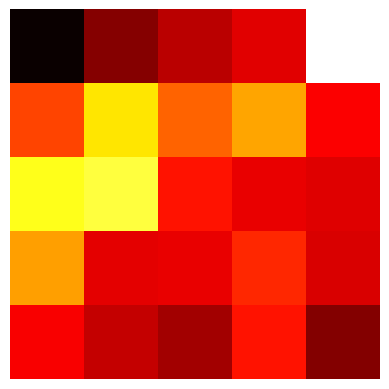

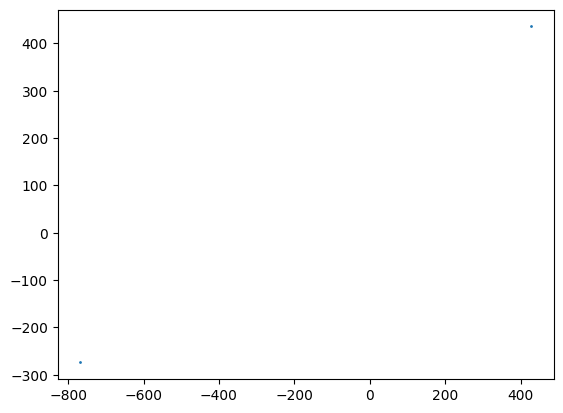

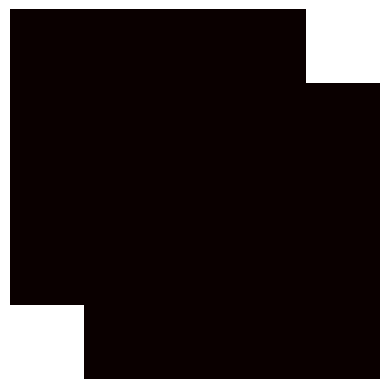

In [31]:
def show_clicks(data:pd.DataFrame, fqid: list, level:int):
    df_plot = data.query('fqid in @fqid and level == @level and event_name != "navigate_click"')
    df_plot = df_plot[['room_coor_x', 'room_coor_y']].dropna()    
    
    plt.scatter(
        x = df_plot.room_coor_x,
        y = df_plot.room_coor_y, 
        s=1)

    plt.show()

    x = df_plot.room_coor_x
    y = df_plot.room_coor_y

    normalized_x = (x - (-1992.3545688360275)) / (1261.7737454550663 - (-1992.3545688360275))
    normalized_y = (y - (-918.1586870421452)) / (543.616424379599 - (-918.1586870421452))    

    heatmap = create_heatmap(normalized_x, normalized_y)
    plt.imshow(heatmap, cmap='hot', origin='lower')
    plt.axis('off')
    plt.show()    

show_clicks(df_source, ['directory'], 15)
show_clicks(df_session, ['directory'], 15)

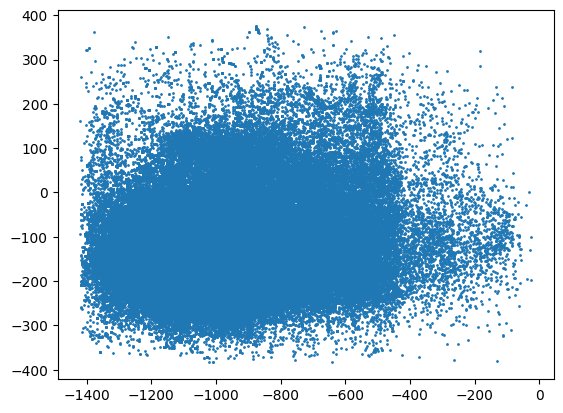

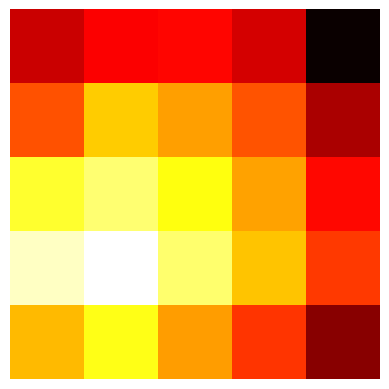

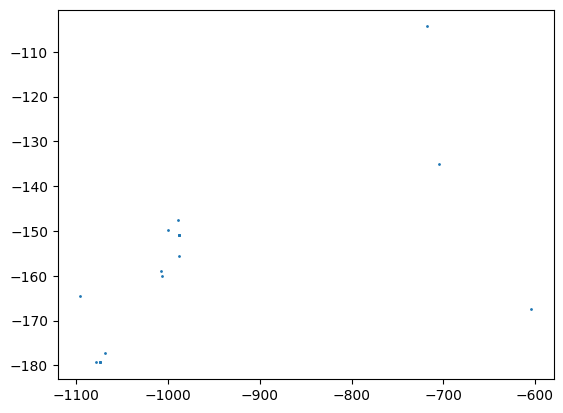

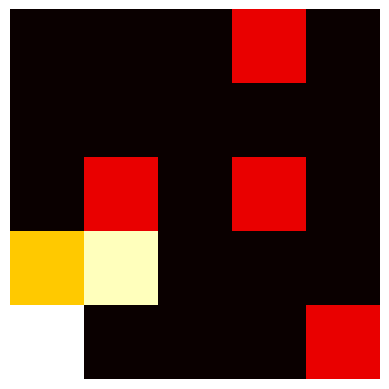

In [32]:
show_clicks(df_source, ['confrontation'], 16)
show_clicks(df_session, ['confrontation'], 16)

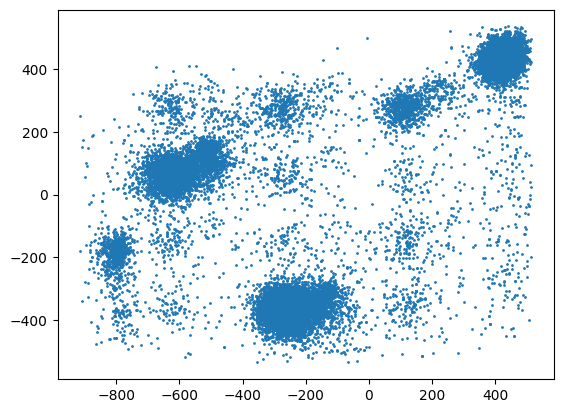

In [33]:
IDX = ((df_source.fqid=='directory.closeup.archivist')|(df_source.fqid=='directory'))&(df_source.level==15)\
    &(df_source.event_name!='navigate_click')
tmp = df_source.loc[IDX]

# plot datapoints as one pixel per click
plt.scatter(tmp.room_coor_x,tmp.room_coor_y, s=1)

tunic.historicalsociety.entry    46282
Name: room_fqid, dtype: int64
tunic.historicalsociety.entry    80666
Name: room_fqid, dtype: int64


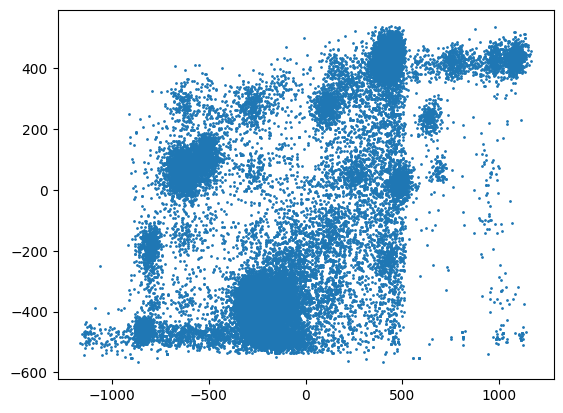

In [34]:
IDX = ((df_source.fqid=='directory.closeup.archivist')|(df_source.fqid=='directory'))&(df_source.level==15)\
    &(df_source.event_name!='navigate_click')
tmp = df_source.loc[IDX]

print(tmp.room_fqid.value_counts())

IDX = (df_source.room_fqid=='tunic.historicalsociety.entry')&(df_source.level==15)\
    &(df_source.event_name!='navigate_click')
tmp = df_source.loc[IDX]

print(tmp.room_fqid.value_counts())
plt.scatter(tmp.room_coor_x,tmp.room_coor_y, s=1)

## Try and find the first question

In [35]:
df_source.text.unique()

array(['undefined', 'Whatcha doing over there, Jo?',
       'Just talking to Teddy.', 'I gotta run to my meeting!',
       'Can I come, Gramps?',
       'Sure thing, Jo. Grab your notebook and come upstairs!',
       'See you later, Teddy.', "I get to go to Gramps's meeting!",
       'Now where did I put my notebook?', '\\u00f0\\u0178\\u02dc\\u00b4',
       nan, 'I love these photos of me and Teddy!', 'Found it!',
       'Gramps is in trouble for losing papers?', "This can't be right!",
       'Gramps is a great historian!', "Hmm. Button's still not working.",
       "Let's get started. The Wisconsin Wonders exhibit opens tomorrow!",
       'Who wants to investigate the shirt artifact?',
       "Not Leopold here. He's been losing papers lately.", 'Hey!',
       "It's true, they do keep going missing lately.", 'See?',
       'Besides, I already figured out the shirt.',
       "It's a women's basketball jersey!", 'That settles it.',
       'Wells, finish up your report.',
       "Leopold

In [36]:
df_source[df_source['text'] == 'The slip is from 1916 but the team didn\'t start until 1974!'].head(2)

,session_id,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
index,,,,,,,,,,,,,,,,,,,
146,20090312431273200,152721,notification_click,basic,3,NaN,523.732308,-112.0,534.0,442.0,NaN,The slip is from 1916 but the team didn't star...,NaN,tunic.kohlcenter.halloffame,tunic.kohlcenter.halloffame.plaque.face.date,NaN,NaN,NaN,0-4
122,20090312433251036,181962,notification_click,basic,3,NaN,269.732329,-267.0,280.0,597.0,NaN,The slip is from 1916 but the team didn't star...,NaN,tunic.kohlcenter.halloffame,tunic.kohlcenter.halloffame.plaque.face.date,NaN,NaN,NaN,0-4


In [37]:
df_group = df_source \
    .assign(fqid_level=df_source['fqid'].astype(str) + '_' + df_source['level'].astype(str)) \
    .groupby(['session_id', 'level_group']) \
    .agg({'fqid_level': 'nunique'}) \
    .reset_index()

display(df_group)


,session_id,level_group,fqid_level
0,20090312431273200,0-4,42
1,20090312431273200,13-22,88
2,20090312431273200,5-12,72
3,20090312433251036,0-4,30
4,20090312433251036,13-22,142
...,...,...,...
35332,22100219442786200,13-22,91
35333,22100219442786200,5-12,70
35334,22100221145014656,0-4,37
35335,22100221145014656,13-22,121


In [38]:
for level_group in df_source.level_group.unique():
    df_group_level = df_group.query('level_group == @level_group')

    print('level_group:', level_group)
    display(df_group_level.fqid_level.describe())

level_group: 0-4


count    11779.000000
mean        33.099414
std          3.677787
min         25.000000
25%         30.000000
50%         32.000000
75%         35.000000
max         56.000000
Name: fqid_level, dtype: float64

level_group: 5-12


count    11779.000000
mean        75.608371
std          7.708821
min         54.000000
25%         70.000000
50%         74.000000
75%         79.000000
max        128.000000
Name: fqid_level, dtype: float64

level_group: 13-22


count    11779.000000
mean        99.607097
std         12.937890
min         71.000000
25%         91.000000
50%         97.000000
75%        105.000000
max        208.000000
Name: fqid_level, dtype: float64

## Bring Some Sanity

uint8


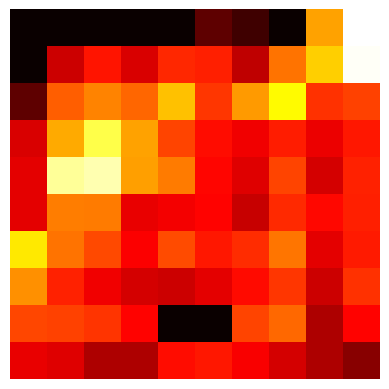

In [39]:
def create_room_heatmap(data: pd.DataFrame, fqid: str, level: int, 
                        bins:int = 10):
                        
    # select the data point to plot
    df_plot = data.query('fqid in @fqid and level == @level and event_name != "navigate_click"')
    df_plot = df_plot[['room_coor_x', 'room_coor_y']].dropna()    

    if (df_plot.shape[0] == 0):
        return np.zeros((bins, bins), dtype=np.uint8)

    # normalize the data points
    normalized_x = (df_plot.room_coor_x - (-1992.3545688360275)) / (1261.7737454550663 - (-1992.3545688360275))
    normalized_y = (df_plot.room_coor_y - (-918.1586870421452)) / (543.616424379599 - (-918.1586870421452))    

    # create the heatmap
    heatmap, xedges, yedges = np.histogram2d(
        x=normalized_y, 
        y=normalized_x, 
        bins=bins)
    
    # Apply logarithmic transformation
    heatmap = np.log(heatmap + 1)

    # Normalize the heatmap
    normalized_heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

    # Scale the heatmap to the range 0-255
    scaled_heatmap = (normalized_heatmap * 255).astype(np.uint8)

    return scaled_heatmap
    
# test the function
heatmap = create_room_heatmap(df_source, 'directory', 15)
print(heatmap.dtype)
plt.imshow(heatmap, cmap='hot', origin='lower')
plt.axis('off')
plt.show()

### Create Session Heatmaps

Tes creating a heatmap for each unique fqid and level.

In [40]:
# get a list of the unique combinations for each level group
df_combinations = df_source \
    .query('event_name != "navigate_click"') \
    .groupby(['level_group', 'fqid', 'level']) \
    .agg({'session_id': 'nunique'}) \
    .reset_index() \
    .loc[lambda x: x['session_id'] > 5000]

display(df_combinations)

,level_group,fqid,level,session_id
6,0-4,chap1_finale_c,4,11779
7,0-4,cs,2,11779
12,0-4,gramps,0,11773
14,0-4,gramps,2,11779
16,0-4,groupconvo,1,11779
...,...,...,...,...
740,5-12,what_happened,5,11779
741,5-12,worker,7,11778
742,5-12,worker,8,11779
743,5-12,worker,9,11779


level_group: 0-4
number of combinations: 17


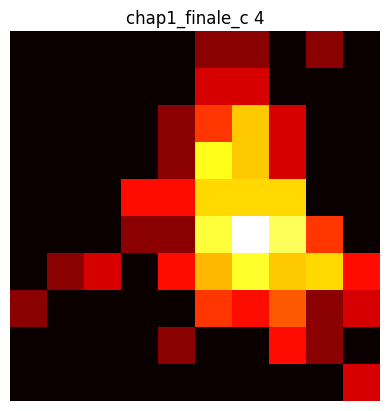

In [41]:
for level_group in df_source.level_group.unique():
    df_group_level = df_combinations \
        .drop(columns=['session_id']) \
        .query('level_group == @level_group') \
        .drop_duplicates() \
        .reset_index(drop=True)

    print('level_group:', level_group)
    print('number of combinations:', df_group_level.shape[0])

    # create a heatmap for each combination
    for i, row in df_group_level.iterrows():
        fqid = row.fqid
        level = row.level
        heatmap = create_room_heatmap(df_source, fqid, level)
        
        plt.imshow(heatmap, cmap='hot', origin='lower')
        plt.axis('off')
        plt.title(fqid + ' ' + str(level))
        plt.show()

        break

    break

## Pre-process Data

### Perform Pre-Processing

In [42]:
# prepare the main dataset
df_source = prepare_main_dataset(df_source)

with pd.option_context('display.max_columns', None):
    print(df_source.shape)
    display(df_source.head(3))  

(13173445, 13)


,session_id,elapsed_time,event_name,name,level,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,fqid,room_fqid,text_fqid,level_group
0,20090312431273200,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0-4
1,20090312431273200,1323,person_click,basic,0,-413.991405,-159.314686,380.0,494.0,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
2,20090312431273200,831,person_click,basic,0,-413.991405,-159.314686,380.0,494.0,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4


In [43]:
# prepare the label dataset
df_source_labels = prepare_label_dataset(df_source_labels)

with pd.option_context('display.max_columns', None):
    display(df_source_labels.sample(n=3, random_state=51))

,session_id,question_num,correct,level_group
21476,22010116250792520,2,1,0-4
84068,21000111433937450,8,1,5-12
171219,21040510125933256,15,0,13-22


In [44]:
gc.collect()

19

## Create Dataset

In [45]:
def create_session_heatmap_dataset(X: pd.DataFrame,
                                   y: pd.DataFrame,
                                   level_group: str,
                                   df_combinations: pd.DataFrame,
                                   pbar: tqdm,
                                   session_list: list):
    
    #logging.info('create_session_heatmap_dataset')
    X_features = []
    y_dataset = []
    
    for session_id in session_list:
        # get the data for the session
        df_session_labels = y.query('session_id == @session_id and level_group == @level_group')
        df_session = X.query('session_id == @session_id and level_group == @level_group')

        # create the answer array
        index_offset = 0
        answer_array = []
        if (level_group == '0-4'):
            index_offset = 1
            answer_array = np.zeros(3)
        elif (level_group == '5-12'):
            index_offset = 4
            answer_array = np.zeros(10)
        elif (level_group == '13-22'):
            index_offset = 14
            answer_array = np.zeros(5)
        else:
            raise ValueError('level_group not supported')

        # iterate over all the questions answered in the session
        heatmap_array = []
        for _, row in df_session_labels.iterrows():
            question_number = row['question_num']
            correct = row['correct']

            # update the answer array
            answer_array[question_number - index_offset] = correct

        # iterate over all the combinations
        for i, row in df_combinations.iterrows():
            fqid = row.fqid
            level = row.level

            heatmap_array.append(create_room_heatmap(df_session, fqid, level))

        # add the features and labels to the dataset
        X_features.append(heatmap_array)
        y_dataset.append(answer_array)

        # update the progress bar
        pbar.update(1)


    # add the features and labels to the dataset
    return X_features, y_dataset


In [46]:
# def create_heatmap_dataset(X: pd.DataFrame,
#                            y: pd.DataFrame,
#                            session_list: list,
#                            level_group: str):

#     X_features = []
#     y_dataset = []

#     # get the unique combinations for the level group     
#     df_combinations = X \
#         .query('event_name != "navigate_click" and level_group == @level_group') \
#         .groupby(['level_group', 'fqid', 'level']) \
#         .agg({'session_id': 'nunique'}) \
#         .reset_index() \
#         .loc[lambda x: x['session_id'] > 5000] \
#         .drop(columns=['session_id']) \
#         .drop_duplicates() \
#         .reset_index(drop=True)
    
#     pbar = tqdm(total=len(session_list))

#     # create the partial function
#     create_session_heatmap_dataset_partial = partial(
#         create_session_heatmap_dataset, X, y, level_group, df_combinations, pbar)

#     pool_size = os.cpu_count() * 4
#     with multiprocessing.pool.ThreadPool(processes=pool_size) as pool:
#         session_results = pool.map(create_session_heatmap_dataset_partial, np.array_split(session_list, math.ceil(len(session_list)/pool_size) * 4))

#         logging.info('Concatenating results')
#         X_features = np.concatenate([x[0] for x in session_results], axis=0)
#         y_dataset = np.concatenate([x[1] for x in session_results], axis=0)

#     pbar.close()
#     X_out = np.array(X_features, dtype=np.float64)
#     y_out = np.array(y_dataset)

#     return X_out, y_out

# # test the function
# X_out, y_out = create_heatmap_dataset(
#     X=df_source, 
#     y=df_source_labels, 
#     session_list=df_source.session_id.unique()[:30],
#     level_group='5-12')

# print(X_out.shape, y_out.shape)

### Old School

In [48]:
def create_heatmap_dataset(X: pd.DataFrame,
                           y: pd.DataFrame,
                           session_list: list,
                           level_group: str):

    X_features = []
    y_dataset = []

    # get the unique combinations for the level group     
    df_combinations = X \
        .query('event_name != "navigate_click" and level_group == @level_group') \
        .groupby(['level_group', 'fqid', 'level']) \
        .agg({'session_id': 'nunique'}) \
        .reset_index() \
        .loc[lambda x: x['session_id'] > 5000] \
        .drop(columns=['session_id']) \
        .drop_duplicates() \
        .reset_index(drop=True)

    for session_id in tqdm(session_list):
        df_session_labels = y.query('session_id == @session_id and level_group == @level_group')
        df_session = X.query('session_id == @session_id and level_group == @level_group')
        
        # create the answer array
        index_offset = 0
        answer_array = []
        if (level_group == '0-4'):
            index_offset = 1
            answer_array = np.zeros(3)
        elif (level_group == '5-12'):
            index_offset = 4
            answer_array = np.zeros(10)
        elif (level_group == '13-22'):
            index_offset = 14
            answer_array = np.zeros(5)
        else:
            raise ValueError('level_group not supported')

        # iterate over all the questions answered in the session
        heatmap_array = []
        for _, row in df_session_labels.iterrows():
            question_number = row['question_num']
            correct = row['correct']

            # update the answer array
            answer_array[question_number - index_offset] = correct

        # iterate over all the combinations
        for i, row in df_combinations.iterrows():
            fqid = row.fqid
            level = row.level

            heatmap_array.append(create_room_heatmap(df_session, fqid, level))   
    
        # add the features and labels to the dataset
        X_features.append(heatmap_array)
        y_dataset.append(answer_array)

    X_out = np.array(X_features, dtype=np.float64)
    y_out = np.array(y_dataset)

    return X_out, y_out
# test the function
X_out, y_out = create_heatmap_dataset(
    X=df_source, 
    y=df_source_labels, 
    session_list=df_source.session_id.unique()[:3],
    level_group='13-22')

print(X_out.shape, y_out.shape)

  0%|          | 0/3 [00:00<?, ?it/s]

(3, 56, 10, 10) (3, 5)


## Parameters

In [49]:
random_state = 51
sample_size = df_source_labels['session_id'].nunique()
#sample_size = 4000
#sample_size = 1000
#sample_size = 500


## Data Selection

In [50]:
train, val, test = select_sessions(
    y=df_source_labels,
    sample_size=sample_size,
    random_state=random_state)

Train: 8245
Validation: 1767
Test: 1767


## Create Datasets

In [51]:
# create the training dataset
X_train_5_12, y_train_5_12 = create_heatmap_dataset(
    X=df_source, 
    y=df_source_labels, 
    session_list=train,
    level_group='5-12',)

  0%|          | 0/8245 [00:00<?, ?it/s]

In [ ]:
# create the validation dataset
X_val_5_12, y_val_5_12 = create_heatmap_dataset(
    X=df_source, 
    y=df_source_labels, 
    session_list=val,
    level_group='5-12')

In [ ]:
# create the testing dataset
X_test_5_12, y_test_5_12 = create_heatmap_dataset(
    X=df_source, 
    y=df_source_labels, 
    session_list=test,
    level_group='5-12')

## Model Training

In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(X_train_5_12.shape[1], X_train_5_12.shape[2], X_train_5_12.shape[3])))
#model.add(MaxPooling2D((2, 2)))
#model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train_5_12.shape[1], activation='sigmoid'))

model.summary()

In [ ]:
train_and_test_model(
    model=model,
    X_train=X_train_5_12,
    y_train=y_train_5_12,
    X_val=X_val_5_12,
    y_val=y_val_5_12,
    X_test=X_test_5_12,
    y_test=y_test_5_12,
    epochs=10,
    batch_size=64,
    optimizer=optimizers.Adam(lr=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [ ]:
model = Sequential()
model.add(Dense(128, input_shape=(X_train_5_12.shape[1], X_train_5_12.shape[2], X_train_5_12.shape[3]), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train_5_12.shape[1], activation='sigmoid'))
model.summary()

In [ ]:
train_and_test_model(
    model=model,
    X_train=X_train_5_12,
    y_train=y_train_5_12,
    X_val=X_val_5_12,
    y_val=y_val_5_12,
    X_test=X_test_5_12,
    y_test=y_test_5_12,
    epochs=10,
    batch_size=64,
    optimizer=optimizers.Adam(lr=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

### This seems to be working well?

In [ ]:
model = Sequential()
model.add(Dense(128, input_shape=(X_train_5_12.shape[1], X_train_5_12.shape[2], X_train_5_12.shape[3]), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train_5_12.shape[1], activation='sigmoid'))
model.summary()

In [ ]:
train_and_test_model(
    model=model,
    X_train=X_train_5_12,
    y_train=y_train_5_12,
    X_val=X_val_5_12,
    y_val=y_val_5_12,
    X_test=X_test_5_12,
    y_test=y_test_5_12,
    epochs=10,
    batch_size=64,
    optimizer=optimizers.Adam(lr=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy'])